In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import joblib

In [2]:
# If Week06 is beside Week05 and Week04:
DATA = "../Week05/datasets"

df = pd.read_csv(f"{DATA}/perovai_week05_day5_decision_table.csv")
print("Rows:", len(df))
df.head()

Rows: 106


,Device,Predicted_Instability_Prob,Risk_Tier,Top_Driver,Anomaly,Voc_V_Reverse,Jsc_mAcm2_Reverse,FF_Reverse,Rs_ohm_cm2_Reverse,Rsh_ohm_cm2_Reverse,Delta_PCE,Hysteresis_Index
0,device008,1.0,High,Rs_ohm_cm2_Reverse,1,1.219800,-0.000019,-0.606497,2.026717e+08,2.381029e+06,4.859762e-06,0.337591
1,device010,1.0,High,Rsh_ohm_cm2_Reverse,0,0.684069,0.008918,0.541720,1.571928e+04,3.474437e+05,4.986416e-04,0.150891
2,device022,1.0,High,Rsh_ohm_cm2_Reverse,0,0.781325,17.895528,0.424888,1.511822e+01,1.091839e+02,1.028520e+00,0.173126
3,device026,1.0,High,Rsh_ohm_cm2_Reverse,0,0.810258,17.882367,0.436219,1.461828e+01,1.202947e+02,1.130071e+00,0.178794
4,device025,1.0,High,Rs_ohm_cm2_Reverse,1,0.476894,0.000006,0.330804,7.367866e+07,2.880276e+07,6.498116e-07,0.671607


In [3]:
model_path_cal = "../Week05/datasets/perovai_best_model_calibrated.pkl"
model_path_raw = "../Week05/datasets/perovai_best_model_week05.pkl"

model = joblib.load(model_path_cal) if os.path.exists(model_path_cal) else joblib.load(model_path_raw)
print("Loaded model:", type(model))

Loaded model: <class 'sklearn.calibration.CalibratedClassifierCV'>


In [4]:
features = [
    "Voc_V_Reverse",
    "Jsc_mAcm2_Reverse",
    "FF_Reverse",
    "Rs_ohm_cm2_Reverse",
    "Rsh_ohm_cm2_Reverse",
    "Delta_PCE",
    "Hysteresis_Index"
]

X = df[features].copy()

In [5]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

k = 4  # you can try 3,4,5 later
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
df["Regime"] = kmeans.fit_predict(X_scaled)

df["Regime"].value_counts()

d:\Anaconda3\envs\perovAI\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Regime
0    70
2    23
1    12
3     1
Name: count, dtype: int64

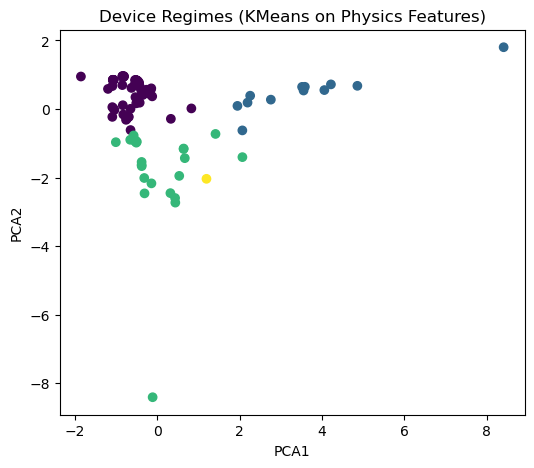

In [6]:
pca = PCA(n_components=2, random_state=42)
xy = pca.fit_transform(X_scaled)

df["PCA1"] = xy[:,0]
df["PCA2"] = xy[:,1]

plt.figure(figsize=(6,5))
plt.scatter(df["PCA1"], df["PCA2"], c=df["Regime"])
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.title("Device Regimes (KMeans on Physics Features)")
plt.show()

In [7]:
regime_summary = df.groupby("Regime")[features + ["Predicted_Instability_Prob"]].agg(["mean","median","std"])
regime_summary

Voc_V_Reverse                     Jsc_mAcm2_Reverse             \
                mean    median       std              mean     median   
Regime                                                                  
0           1.049136  1.101768  0.145119         18.991004  20.148954   
1           1.143718  1.170200  0.124456          0.000005   0.000005   
2           0.358638  0.356715  0.306130          7.667875  12.060800   
3           0.931900  0.931900       NaN          4.260528   4.260528   

                 FF_Reverse                     Rs_ohm_cm2_Reverse  ...  \
             std       mean    median       std               mean  ...   
Regime                                                              ...   
0       3.985479   0.631641  0.739719  0.174016       9.507238e+04  ...   
1       0.000001   0.859504  0.828665  0.157577       4.118322e+08  ...   
2       6.597631  -0.169574  0.265592  1.906093       1.290716e+07  ...   
3            NaN   0.000001  0.000001       NaN       8.914104e+07  ...   

       Rsh_ohm_cm2_Reverse Delta_PCE                     Hysteresis_Index  \
                       std      mean    median       std             mean   
Regime                                                                      
0             1.243523e+05  0.380802  0.484952  0.528845         0.066608   
1             1.926698e+07  0.000004  0.000004  0.000002         0.741526   
2             5.994317e+06  0.195354  0.001365  0.270931         0.247393   
3                      NaN  0.008557  0.008557       NaN      1810.071312   

                              Predicted_Instability_Prob                \
             median       std                       mean        median   
Regime                                                                   
0          0.030022  0.131099                   0.257143  1.451066e-07   
1          0.887200  0.339630                   1.000000  9.999998e-01   
2          0.224838  0.259186                   0.874118  9.999998e-01   
3       1810.071312       NaN                   1.000000  9.999998e-01   

                      
                 std  
Regime                
0       4.402144e-01  
1       8.134247e-10  
2       3.042418e-01  
3                NaN  

[4 rows x 24 columns]

In [8]:
df.sort_values("Predicted_Instability_Prob", ascending=False).groupby("Regime").head(10)[
    ["Device","Regime","Predicted_Instability_Prob","Top_Driver","Anomaly"]
]

,Device,Regime,Predicted_Instability_Prob,Top_Driver,Anomaly
0,device008,2,1.0,Rs_ohm_cm2_Reverse,1
1,device010,2,1.0,Rsh_ohm_cm2_Reverse,0
2,device022,0,1.0,Rsh_ohm_cm2_Reverse,0
3,device026,0,1.0,Rsh_ohm_cm2_Reverse,0
4,device025,2,1.0,Rs_ohm_cm2_Reverse,1
5,device042,0,1.0,Rsh_ohm_cm2_Reverse,0
6,device023,0,1.0,Rsh_ohm_cm2_Reverse,0
7,device046,0,1.0,Rsh_ohm_cm2_Reverse,0
8,device045,0,1.0,Rsh_ohm_cm2_Reverse,0
9,device043,2,1.0,Jsc_mAcm2_Reverse,0


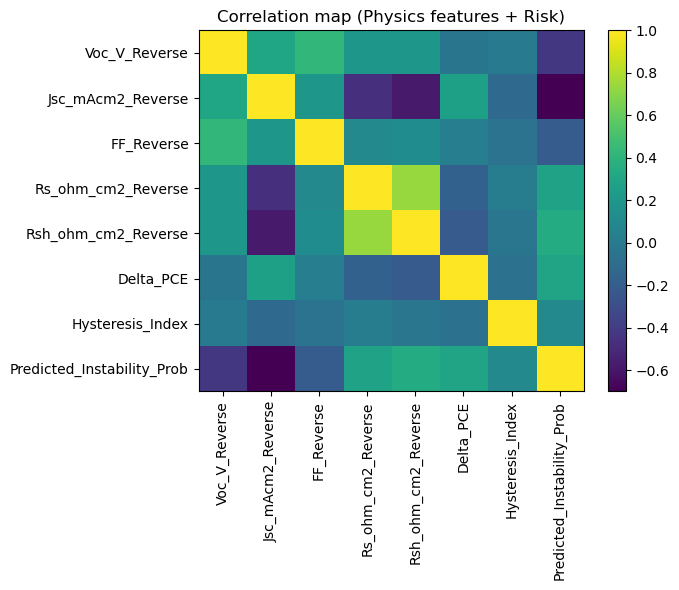

In [9]:
corr = df[features + ["Predicted_Instability_Prob"]].corr()

plt.figure(figsize=(7,6))
plt.imshow(corr, aspect="auto")
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.index)), corr.index)
plt.title("Correlation map (Physics features + Risk)")
plt.colorbar()
plt.tight_layout()
plt.show()

In [10]:
base = df[features].copy()

def predict_prob(Xdf):
    if hasattr(model, "predict_proba"):
        return model.predict_proba(Xdf)[:,1]
    # fallback
    return model.predict(Xdf)

df["Risk_Base"] = predict_prob(base)

# perturbations
scenarios = {
    "Rs_plus20": base.assign(Rs_ohm_cm2_Reverse = base["Rs_ohm_cm2_Reverse"]*1.20),
    "DeltaPCE_plus20": base.assign(Delta_PCE = base["Delta_PCE"]*1.20),
    "Hyst_plus20": base.assign(Hysteresis_Index = base["Hysteresis_Index"]*1.20),
    "Jsc_minus10": base.assign(Jsc_mAcm2_Reverse = base["Jsc_mAcm2_Reverse"]*0.90),
    "Voc_minus10mV": base.assign(Voc_V_Reverse = base["Voc_V_Reverse"] - 0.010),
}

for name, Xs in scenarios.items():
    df[f"Risk_{name}"] = predict_prob(Xs)
    df[f"DeltaRisk_{name}"] = df[f"Risk_{name}"] - df["Risk_Base"]

df[[c for c in df.columns if c.startswith("DeltaRisk_")]].describe()

,DeltaRisk_Rs_plus20,DeltaRisk_DeltaPCE_plus20,DeltaRisk_Hyst_plus20,DeltaRisk_Jsc_minus10,DeltaRisk_Voc_minus10mV
count,106.0,106.0,106.0,106.0,106.0
mean,0.0,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0


In [11]:
for name in scenarios:
    col = f"DeltaRisk_{name}"
    print("\n", name, "most sensitive devices:")
    print(df.sort_values(col, ascending=False)[["Device","Regime","Risk_Base",col,"Top_Driver","Anomaly"]].head(10))


 Rs_plus20 most sensitive devices:
      Device  Regime  Risk_Base  DeltaRisk_Rs_plus20           Top_Driver  \
0  device008       2        1.0                  0.0   Rs_ohm_cm2_Reverse   
1  device010       2        1.0                  0.0  Rsh_ohm_cm2_Reverse   
2  device022       0        1.0                  0.0  Rsh_ohm_cm2_Reverse   
3  device026       0        1.0                  0.0  Rsh_ohm_cm2_Reverse   
4  device025       2        1.0                  0.0   Rs_ohm_cm2_Reverse   
5  device042       0        1.0                  0.0  Rsh_ohm_cm2_Reverse   
6  device023       0        1.0                  0.0  Rsh_ohm_cm2_Reverse   
7  device046       0        1.0                  0.0  Rsh_ohm_cm2_Reverse   
8  device045       0        1.0                  0.0  Rsh_ohm_cm2_Reverse   
9  device043       2        1.0                  0.0    Jsc_mAcm2_Reverse   

   Anomaly  
0        1  
1        0  
2        0  
3        0  
4        1  
5        0  
6        0  
7        0  

In [12]:
os.makedirs("datasets", exist_ok=True)

df.to_csv("datasets/perovai_week06_lite_regimes_whatif.csv", index=False)
regime_summary.to_csv("datasets/perovai_week06_lite_regime_summary.csv")

print("Saved:")
print(" - datasets/perovai_week06_lite_regimes_whatif.csv")
print(" - datasets/perovai_week06_lite_regime_summary.csv")

Saved:
 - datasets/perovai_week06_lite_regimes_whatif.csv
 - datasets/perovai_week06_lite_regime_summary.csv


In [13]:
regime_desc = df.groupby("Regime")[[
    "Delta_PCE","Hysteresis_Index","Rs_ohm_cm2_Reverse","Jsc_mAcm2_Reverse","Voc_V_Reverse"
]].mean()

regime_desc

,Delta_PCE,Hysteresis_Index,Rs_ohm_cm2_Reverse,Jsc_mAcm2_Reverse,Voc_V_Reverse
Regime,,,,,
0,0.380802,0.066608,9.507238e+04,18.991004,1.049136
1,0.000004,0.741526,4.118322e+08,0.000005,1.143718
2,0.195354,0.247393,1.290716e+07,7.667875,0.358638
3,0.008557,1810.071312,8.914104e+07,4.260528,0.931900


In [14]:
def name_regime(row):
    if row["Delta_PCE"] > df["Delta_PCE"].median() and row["Hysteresis_Index"] > df["Hysteresis_Index"].median():
        return "Interface / Ionic dominated"
    if row["Rs_ohm_cm2_Reverse"] > df["Rs_ohm_cm2_Reverse"].median():
        return "Transport limited"
    if row["Jsc_mAcm2_Reverse"] > df["Jsc_mAcm2_Reverse"].median() and row["Hysteresis_Index"] < df["Hysteresis_Index"].median():
        return "High performance stable"
    return "Mixed / intermediate"

regime_names = regime_desc.apply(name_regime, axis=1)
regime_names

Regime
0    Interface / Ionic dominated
1              Transport limited
2    Interface / Ionic dominated
3              Transport limited
dtype: object

In [15]:
df["Regime_Name"] = df["Regime"].map(regime_names)
df[["Device","Regime","Regime_Name"]].head(10)

,Device,Regime,Regime_Name
0,device008,2,Interface / Ionic dominated
1,device010,2,Interface / Ionic dominated
2,device022,0,Interface / Ionic dominated
3,device026,0,Interface / Ionic dominated
4,device025,2,Interface / Ionic dominated
5,device042,0,Interface / Ionic dominated
6,device023,0,Interface / Ionic dominated
7,device046,0,Interface / Ionic dominated
8,device045,0,Interface / Ionic dominated
9,device043,2,Interface / Ionic dominated


In [16]:
threshold = 0.3  # target safe probability

def suggest_change(row):
    if row["Predicted_Instability_Prob"] < threshold:
        return "No change needed"

    if row["DeltaRisk_DeltaPCE_plus20"] > 0.1:
        return "Reduce hysteresis / scan mismatch"
    if row["DeltaRisk_Rs_plus20"] > 0.1:
        return "Reduce series resistance"
    if row["DeltaRisk_Jsc_minus10"] > 0.1:
        return "Improve charge collection"

    return "General optimization"

df["Action_Suggestion"] = df.apply(suggest_change, axis=1)
df[["Device","Predicted_Instability_Prob","Regime_Name","Action_Suggestion"]].head(20)

,Device,Predicted_Instability_Prob,Regime_Name,Action_Suggestion
0,device008,1.0,Interface / Ionic dominated,General optimization
1,device010,1.0,Interface / Ionic dominated,General optimization
2,device022,1.0,Interface / Ionic dominated,General optimization
3,device026,1.0,Interface / Ionic dominated,General optimization
4,device025,1.0,Interface / Ionic dominated,General optimization
5,device042,1.0,Interface / Ionic dominated,General optimization
6,device023,1.0,Interface / Ionic dominated,General optimization
7,device046,1.0,Interface / Ionic dominated,General optimization
8,device045,1.0,Interface / Ionic dominated,General optimization
9,device043,1.0,Interface / Ionic dominated,General optimization


In [17]:
df.to_csv("datasets/perovai_week06_lite_with_actions.csv", index=False)